# Assignment 3

In [ ]:
from sympy import * 
import numpy as np
import matplotlib.pyplot as plt
from dtumathtools import *
from sympy.physics.units import *
import math
init_printing()  

## Task 6

In [26]:
# Constant parameters

# Ingenuity parameters
R_prop_Ingenuity = 0.6 #m
omega_Ingenuity = 2800 * pi / 30 #rad/s (propeller rotation speed)

# Mars atmosphere data
rho_mars = 0.017 #kg/m^3
g_mars = 3.71 #m/s^2

# Losses and other datapoints
C_d0 = 0.02 #zero-lift drag coefficient
C_D_body = 0.4 #body drag coefficient
A_aircraft = 0.5 #m^2 (Assumes body frontal area)
gamma = 1.15 #Assumed
c = 0.14 #Assumed
U = 10 #m/s (ground speed)
rho_wing = 74 #kg/m^3 (wing density)


# Design parameters (two rotor design)
m_no_wing = 4.92 #kg 
R_prop = 1.22 #m (rotor radius)
n_prop = 2 #number of rotors
n_blade = 2 #number of blades per rotor

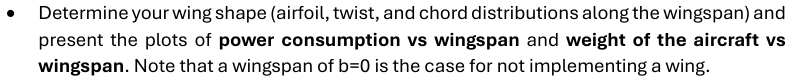

In [27]:
# Function to calculate weight, drag, lift, thrust and resultant force for different aspect ratios

def calculate_parameters(AR, rho_wing, b):
    W_A = m_no_wing * g_mars # Weight of the aircraft (N)
    D_A = 1/2 * rho_mars * C_D_body * U**2 * A_aircraft # Drag of the aircraft (N)

    # We choose a rectangular wing with a S1091_xtr01 airfoil, constant chord and no twist.
    t_max = 0.051  # Maximum thickness-to-chord ratio (5.1%)
    C_D = 0.03741  # Drag coefficient for 2D airfoil at best C_d vs. C_l ratio 
    C_L = 1.0686  # Lift coefficient for 2D airfoil at best C_d vs. C_l ratio
    e = 0.8  # Oswald efficiency factor for rectangular wing (assumed)


    # Weight and drag of the wing:
    S = b**2 / AR  # Wing surface area (m^2)
    t = t_max * (b/AR) # Maximum thickness of the wing (m)
    V = S * t  # Volume of the wing (m^3) assuming maximum thickness as constant for conservative estimate
    W_W = rho_wing * V * g_mars  # Weight of the wing (N)

    D_2d = 1/2 * rho_mars * C_D * U**2 * S  # Drag of the 2D airfoil (N)
    C_D_i = (C_L**2)/pi * AR * e  # Induced drag coefficient
    D_i = 1/2 * rho_mars * C_D_i * U**2 * S  # Induced drag of the wing (N)
    D_W = D_2d + D_i  # Total drag of the wing (N)


    # Lift of the wing:
    S = b**2 / AR  # Wing surface area (m^2)
    L_W = 1/2 * rho_mars * C_L * U**2 * S  # Lift of the wing (N)


    # Resulting forces acting on the aircraft:
    F_x = D_W + D_A  # Total drag (N) acting backwards
    F_z = W_W + W_A - L_W  # Total weight (N) acting downwards
    F_res = sqrt(F_x**2 + F_z**2)  # Resultant force (N) acting on the aircraft

    # The resulting force has to be equal to the thrust produced by the propellers:
    T = F_res  # Thrust (N) produced by the propellers

    # Calculating resultant force angle:
    Phi = atan(F_x / F_z)  # Angle of the resultant force (radians)

    return W_W, D_W, L_W, T, Phi, W_A, D_A


Thrust at hover (T_H): 18.2532
Hover rotation speed (omega_H): 144.161424631879
Thrust coefficient (k): 0.000878295952758258


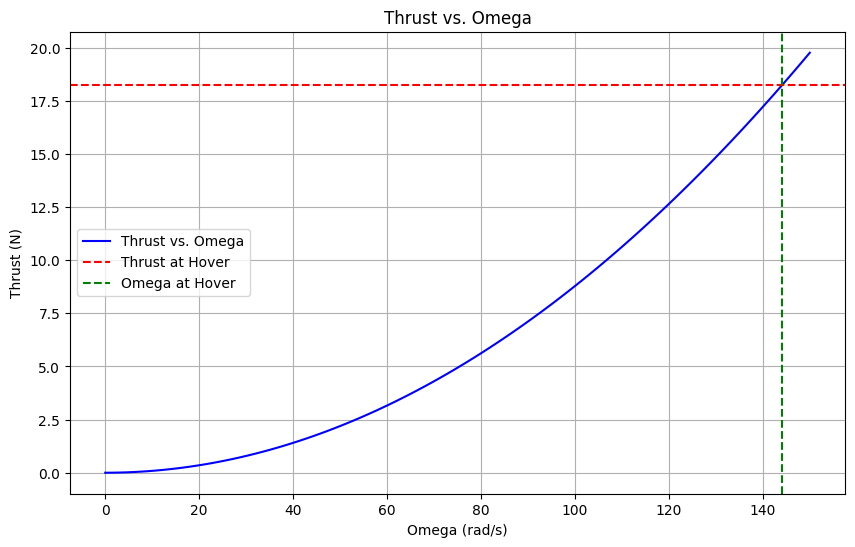

In [28]:
# Defining a function for omega based on rpm and thrust at hover
T_0 = 0
omega_0 = 0

T_H = m_no_wing * g_mars # thrust required to hover (N)
print("Thrust at hover (T_H):", T_H)
omega_H = 1376.6402 * pi / 30 # hover rotation speed (rad/s)
print("Hover rotation speed (omega_H):", omega_H.evalf())

# Calculating k in the function T = k * omega^2 based on thrust at hover
k = T_H / omega_H**2  # Thrust coefficient (N/(rad/s)^2)
print("Thrust coefficient (k):", k.evalf())


# Plotting the function T = k * omega^2
omega_vals = np.linspace(0, 150, 100)  # Range of omega values (rad/s)
T_vals = k * omega_vals**2  # Thrust values (N) based on the function
plt.figure(figsize=(10, 6))
plt.plot(omega_vals, T_vals, label='Thrust vs. Omega', color='blue')
plt.axhline(y=T_H, color='red', linestyle='--', label='Thrust at Hover')
plt.axvline(x=omega_H, color='green', linestyle='--', label='Omega at Hover')
plt.title('Thrust vs. Omega')
plt.xlabel('Omega (rad/s)')
plt.ylabel('Thrust (N)')
plt.legend()
plt.grid()
plt.show()

print()

In [29]:
# Iterative solver for induced velocity v_i
def solve_vi(v_guess, v_H, V_inf, Beta):

    # Initial guess for v_i (start with v_H as a reasonable guess)
    v_i = v_guess
    
    # Precompute constants
    V_inf_cos_beta = V_inf * cos(Beta)
    V_inf_sin_beta = V_inf * sin(Beta)
    v_H_squared = v_H ** 2

    tolerance = 0.1 # Convergence tolerance
    max_iterations = 100 # Maximum number of iterations
    
    # Iterative loop
    for i in range(max_iterations):
        # Compute the denominator: sqrt((V_inf * cos(beta))^2 + (V_inf * sin(beta) + v_i)^2)
        denominator = sqrt(V_inf_cos_beta ** 2 + (V_inf_sin_beta + v_i) ** 2)
        
        # Compute the new v_i using the equation
        v_i_new = v_H_squared / denominator
        
        # Check for convergence
        diff = abs(v_i_new - v_i).evalf() 
        if diff < tolerance:
            return v_i_new
        
        # Update v_i for the next iteration
        v_i = v_i_new
    
    # If we reach here, the solution didn't converge
    raise ValueError("v_i did not converge within the maximum number of iterations")

In [30]:
# Calculating power consumption and plotting vs wingspan:
def calculate_power(AR_values, rho_wing, b_values):

    # Create a plot to add each AR to
    plt.figure(figsize=(7, 5))
    plt.title('Total Power consumption vs wingspan for different aspect ratios')
    plt.xlabel('Wingspan [m]')
    plt.ylabel('Total Power (P) Required [W]')
    plt.grid()

    P_values_dict = {} # Dictionary to store P_values for each AR

    for AR in AR_values:
        P_values = []  # List to store power values for the current AR

        for b in b_values:
            W_W, D_W, L_W, T, Phi, W_A, D_A = calculate_parameters(AR, rho_wing, b)  # Unpack the returned values

            T_rotor = T / 2  # Thrust per rotor (N)  
            Beta = Phi  # Angle of the thrust (radians)

            # Using function for thrust to calculate omega 
            omega = sqrt(T_rotor / k)  # Rotation speed (rad/s) based on thrust

            # Calculating v_i:
            T_H = (W_A + W_W)/2  # thrust required to hover per roter with wings attached (N)
            v_H = sqrt(T_H / (2 * rho_mars * pi * R_prop**2))  # Induced velocity (m/s) at hover under each rotor
            v_guess = 5 + (b/3) # Initial guess for v_i
            v_i = solve_vi(v_guess, v_H, U, Beta)

            P_ideal = T_rotor * (U * sin(Beta) + v_i) #W (ideal power required to for forward flight)
            P_0 = (1/8) * rho_mars * n_blade * omega**3 * C_d0 * (c/R_prop) * R_prop**5 #W (power required for forward flight due to losses)
            P = (gamma * P_ideal + P_0) * n_prop #W (Total power required to hover)

            # Append the evaluated power value for the current wingspan
            P_values.append(P.evalf())

        # Store the P_values for the current AR in the dictionary
        P_values_dict[AR] = P_values

        # Plot the power values for the current AR
        plt.plot(b_values, P_values, label=f'Aspect ratio {AR}')


    # Add legend and show the plot
    plt.legend()
    plt.show()

# Note that a wingspan of b=0 is the case for not implementing a wing. 

In [ ]:
# ploting
AR_values = [4, 6, 8, 10, 12]  # Aspect ratios
b_values = np.linspace(0.1, 0.5, 20)  # Wingspan values (m) # Wingspan (m)
calculate_power(AR_values, rho_wing, b_values)

In [ ]:
# Calculating weight of the aircraft and plotting vs wingspan:

# Create a plot to add each AR to
fig, ax1 = plt.subplots(figsize=(7, 5))

# Primary y-axis (Weight in Newtons)
ax1.set_title('Weight of the aircraft vs wingspan for different aspect ratios')
ax1.set_xlabel('Wingspan [m]')
ax1.set_ylabel('Weight of the aircraft [N]', color='blue')
ax1.grid()

AR_values = [4, 6, 8, 10, 12]  # Aspect ratios
b_values = np.linspace(0.1, 0.5, 20)  # Wingspan values (m)

for AR in AR_values:
    W_values = []  # List to store weight values for the current AR

    for b in b_values:
        W_W, D_W, L_W, T, Phi, W_A, D_A = calculate_parameters(AR, rho_wing, b)  # Unpack the returned values
        W_total = W_A + W_W
        W_values.append(W_total)  # Append the evaluated weight value for the current wingspan

    # Add the graph for the current aspect ratio
    ax1.plot(b_values, W_values, label=f'Aspect ratio {AR}')

# Secondary y-axis (Weight in kilograms)
ax2 = ax1.twinx()
ax2.set_ylabel('Weight of the aircraft [kg]', color='red')
ax2.set_ylim(ax1.get_ylim()[0] / g_mars, ax1.get_ylim()[1] / g_mars)  # Convert N to kg

# Add legend and show the plot
ax1.legend(loc='upper left')
plt.show()


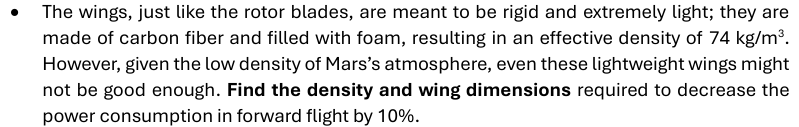

In [33]:
def power_no_wing(U):
    W_A = m_no_wing * g_mars # Weight of the aircraft (N)
    D_A = 1/2 * rho_mars * C_D_body * U**2 * A_aircraft # Drag of the aircraft (N)

    # Resulting forces acting on the aircraft:
    F_x = D_A  # Total drag (N) acting backwards
    F_z = W_A  # Total weight (N) acting downwards
    F_res = sqrt(F_x**2 + F_z**2)  # Resultant force (N) acting on the aircraft

    # The resulting force has to be equal to the thrust produced by the propellers:
    T = F_res  # Thrust (N) produced by the propellers

    # Calculating resultant force angle:
    Phi = atan(F_x / F_z)  # Angle of the resultant force (radians)

    T_rotor = T / 2  # Thrust per rotor (N)  
    Beta = Phi  # Angle of the thrust (radians)

    # Using function for thrust to calculate omega 
    omega = sqrt(T_rotor / k)  # Rotation speed (rad/s) based on thrust

    # Calculating v_i:
    T_H = (W_A)/2  # thrust required to hover per roter with wings attached (N)
    v_H = sqrt(T_H / (2 * rho_mars * pi * R_prop**2))  # Induced velocity (m/s) at hover under each rotor
    v_guess = T_H # Initial guess for v_i
    v_i = solve_vi(v_guess, v_H, U, Beta)

    P_ideal = T_rotor * (U * sin(Beta) + v_i) #W (ideal power required to for forward flight)
    P_0 = (1/8) * rho_mars * n_blade * omega**3 * C_d0 * (c/R_prop) * R_prop**5 #W (power required for forward flight due to losses)
    P = (gamma * P_ideal + P_0) * n_prop #W (Total power required to hover)

    return T, Phi, P

In [34]:
# Power consumption with no wing
T, Phi, P = power_no_wing(U)  # Unpack the returned values

print("Power consumption with no wing:", P.evalf(), 'W')
print("Power consumption needed to reduce power by 10%:", P.evalf() * 0.9, 'W')

Power consumption with no wing: 164.938106918858 W
Power consumption needed to reduce power by 10%: 148.444296226972 W


In [ ]:
# Same code is run for different densities of the wing material
AR_values = [4, 6, 8, 10, 12]  # Aspect ratios
b_values = np.linspace(0.1, 5, 20)  # Wingspan values (m) # Wingspan (m)
rho_wing = 1 #kg/m^3 (wing density)
calculate_power(AR_values, rho_wing, b_values)

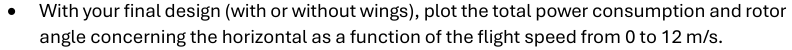

In [ ]:
def solve_vi_2(v_guess, v_H, V_inf, Beta):

    # Initial guess for v_i (start with v_H as a reasonable guess)
    v_i = v_guess
    
    # Precompute constants
    V_inf_cos_beta = V_inf * math.cos(Beta)
    V_inf_sin_beta = V_inf * math.sin(Beta)
    v_H_squared = v_H ** 2

    tolerance = 0.1 # Convergence tolerance
    max_iterations = 1000 # Maximum number of iterations
    
    # Iterative loop
    for i in range(max_iterations):
        # Compute the denominator: sqrt((V_inf * cos(beta))^2 + (V_inf * sin(beta) + v_i)^2)
        denominator = math.sqrt(V_inf_cos_beta ** 2 + (V_inf_sin_beta + v_i) ** 2)
        
        # Compute the new v_i using the equation
        v_i_new = v_H_squared / denominator
        
        # Check for convergence
        diff = abs(v_i_new - v_i).evalf() 
        if diff < tolerance:
            return v_i_new
        
        # Update v_i for the next iteration
        v_i = v_i_new
    
    # If we reach here, the solution didn't converge
    raise ValueError("v_i did not converge within the maximum number of iterations")

In [ ]:
def power_no_wing_2(U):
    W_A = m_no_wing * g_mars # Weight of the aircraft (N)
    D_A = 1/2 * rho_mars * C_D_body * U**2 * A_aircraft # Drag of the aircraft (N)

    # Resulting forces acting on the aircraft:
    F_x = D_A  # Total drag (N) acting backwards
    F_z = W_A  # Total weight (N) acting downwards
    F_res = sqrt(F_x**2 + F_z**2)  # Resultant force (N) acting on the aircraft

    # The resulting force has to be equal to the thrust produced by the propellers:
    T = F_res  # Thrust (N) produced by the propellers

    # Calculating resultant force angle:
    Phi = atan(F_x / F_z)  # Angle of the resultant force (radians)

    T_rotor = T / 2  # Thrust per rotor (N)  
    Beta = Phi  # Angle of the thrust (radians)

    # Using function for thrust to calculate omega 
    omega = sqrt(T_rotor / k)  # Rotation speed (rad/s) based on thrust

    # Calculating v_i:
    T_H = (W_A)/2  # thrust required to hover per roter with wings attached (N)
    v_H = sqrt(T_H / (2 * rho_mars * pi * R_prop**2))  # Induced velocity (m/s) at hover under each rotor
    v_guess = T_H # Initial guess for v_i
    v_i = solve_vi_2(v_guess, v_H, U, Beta)

    P_ideal = T_rotor * (U * sin(Beta) + v_i) #W (ideal power required to for forward flight)
    P_0 = (1/8) * rho_mars * n_blade * omega**3 * C_d0 * (c/R_prop) * R_prop**5 #W (power required for forward flight due to losses)
    P = (gamma * P_ideal + P_0) * n_prop #W (Total power required to hover)
    Phi_deg = (Phi * 180 / pi).evalf() 
    return T, Phi_deg, P

In [ ]:
U_values = np.linspace(0.5, 12, 30)  # Ground speed values (m/s)
P_values = []  # List to store power values for the current AR
Phi_values = []  # List to store angle values for the current AR

for U in U_values:
    T, Phi, P = power_no_wing_2(U)  # Unpack the returned values

    # Append the evaluated power value for the current wingspan
    P_values.append(P.evalf())
    Phi_values.append(Phi.evalf())
    
#1) Opret figur og første akse
fig, ax1 = plt.subplots(figsize=(7, 6))

# 2) Plot Power Consumption på ax1
ax1.plot(U_values, P_values, linestyle='-', color='blue', label='Power Consumption')
ax1.set_xlabel('Flight Speed (m/s)', fontsize=12)
ax1.set_ylabel('Power Consumption (W)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 3) Opret twin-akse for Rotor angle
ax2 = ax1.twinx()
ax2.plot(U_values, Phi_values, linestyle='--', color='orange', label='Rotor angle')
ax2.set_ylabel('Rotor angle (°)', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 4) Fælles titel, grid og legend
plt.title('Flight Speed vs. Power & Rotor Angle', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)

# Samlet legend – henter alle handles/labels fra begge akser
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=10, loc='upper left')

plt.tight_layout()
plt.show()